# PHASE 4 PROJECT - CITY OF CHICAGO ACCIDENTS .

**Authors** : Eugene Maina, Beryl Okelo, Beth Nyambura.

## OVERVIEW

This is a project that aims to build a model to predict the primary causes of road accidents within the City of Chicago.

### Business Problem and Stakeholders.

<img src = 'images\Flag_of_Chicago,_Illinois.svg' width = 200 >

* The City of Chicago Traffic safety board would like to gain further insights of the primary contributory causes of road accidents in the city to help develop targeted interventions.The objective is to build a model that can predict the primary contributory cause of a car accident, given information about the car, the people in the car, the road conditions etc.

* As per Illinois statute, only crashes with a property damage value of $1,500 or more or involving bodily injury to any person(s) and that happen on a public roadway and that involve at least one moving vehicle, except bike dooring, are considered reportable crashes.


* The overall main business questions are:

1. What are the top 10 primary contributors of road accidents?
2. What accidents cause the most fatalities?
3. What period do accidents commonly occur by month?

## DATA UNDERSTANDING

* First step is to load the necessary dependencies and the dataset that will be used to achieve this objective.

In [3]:
# Importing the necessary dependencies.
# Base dependencies.

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
%matplotlib inline

# Setting the style of the plots
sns.set_style('darkgrid', {'axes.facecolor': '0.9'})

# Machine learning dependencies

from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, StandardScaler ,LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report, roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from catboost import CatBoostClassifier

# Imbalancing dependencies

from imblearn.over_sampling import SMOTE

# Interpretability dependencies

import eli5



* Then we have to import and read through the first 5 rows of the dataset to see what we are dealing with.

* The dataset can be found on [Chicago Data Portal](https://data.cityofchicago.org/Transportation/Traffic-Crashes-Crashes/85ca-t3if/about_data)



In [4]:
raw_data = pd.read_csv("data/traffic_Crashes.csv")

raw_data.head()

,CRASH_RECORD_ID,CRASH_DATE_EST_I,CRASH_DATE,POSTED_SPEED_LIMIT,TRAFFIC_CONTROL_DEVICE,DEVICE_CONDITION,WEATHER_CONDITION,LIGHTING_CONDITION,FIRST_CRASH_TYPE,TRAFFICWAY_TYPE,...,INJURIES_NON_INCAPACITATING,INJURIES_REPORTED_NOT_EVIDENT,INJURIES_NO_INDICATION,INJURIES_UNKNOWN,CRASH_HOUR,CRASH_DAY_OF_WEEK,CRASH_MONTH,LATITUDE,LONGITUDE,LOCATION
0,01184614b08579d6befa7734427e750d0f10e79dc0aa42...,NaN,04/04/2025 01:57:00 AM,15,NO CONTROLS,NO CONTROLS,CLEAR,"DARKNESS, LIGHTED ROAD",ANGLE,PARKING LOT,...,0.0,0.0,2.0,0.0,1,6,4,41.766021,-87.572442,POINT (-87.572442196614 41.766020695126)
1,01db2b5a81860ebd2fa3f4564ba0de00508847313ce23a...,NaN,04/24/2025 08:40:00 PM,10,NO CONTROLS,NO CONTROLS,CLEAR,DAYLIGHT,REAR TO SIDE,PARKING LOT,...,0.0,0.0,2.0,0.0,20,5,4,41.875048,-87.744921,POINT (-87.744921303711 41.875047815678)
2,0583b2385710470c0a1bc80417d095512e3d04d6f26158...,NaN,04/24/2025 05:45:00 AM,30,TRAFFIC SIGNAL,FUNCTIONING PROPERLY,CLEAR,DAWN,TURNING,NOT DIVIDED,...,0.0,0.0,2.0,0.0,5,5,4,41.981238,-87.806997,POINT (-87.806997368434 41.981238161467)
3,05d78a76ea643730a5771ac904b43c56236f332b42db0e...,NaN,04/24/2025 11:13:00 AM,30,NO CONTROLS,NO CONTROLS,CLEAR,DAYLIGHT,FIXED OBJECT,ALLEY,...,0.0,1.0,0.0,0.0,11,5,4,41.742295,-87.652157,POINT (-87.652156998855 41.742294907932)
4,00a530520c84927490b597a6220ff3f2a3347472ef3086...,NaN,01/15/2025 01:50:00 PM,30,NO CONTROLS,NO CONTROLS,CLEAR,DAYLIGHT,FIXED OBJECT,RAMP,...,0.0,0.0,1.0,0.0,13,4,1,41.816073,-87.656743,POINT (-87.656742699936 41.816073475493)


* We can also use the pandas `.info()` method to get more information on the dataset.

In [5]:
# Attaining information on the various columns.

raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 955502 entries, 0 to 955501
Data columns (total 48 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   CRASH_RECORD_ID                955502 non-null  object 
 1   CRASH_DATE_EST_I               69903 non-null   object 
 2   CRASH_DATE                     955502 non-null  object 
 3   POSTED_SPEED_LIMIT             955502 non-null  int64  
 4   TRAFFIC_CONTROL_DEVICE         955502 non-null  object 
 5   DEVICE_CONDITION               955502 non-null  object 
 6   WEATHER_CONDITION              955502 non-null  object 
 7   LIGHTING_CONDITION             955502 non-null  object 
 8   FIRST_CRASH_TYPE               955502 non-null  object 
 9   TRAFFICWAY_TYPE                955502 non-null  object 
 10  LANE_CNT                       199026 non-null  float64
 11  ALIGNMENT                      955502 non-null  object 
 12  ROADWAY_SURFACE_COND          

* Then we can check for the number of columns that are numerical or categorical.This will be important later on when we have to decide what type of models we would want to deploy.

In [6]:
# Splitting the data into categorical and numerical columns.

categorical = [col for col in raw_data.columns if raw_data[col].dtype=='object']
numerical = [col for col in raw_data.columns if col not in categorical]

# Then checking the number of columns that are numerical or categorical.
print(f"Number of categorical columns: {len(categorical)}")
print(f"Number of numerical columns: {len(numerical)}")

Number of categorical columns: 31
Number of numerical columns: 17


* Now we can check for the missing values in the columns.First we do the categorical.

In [7]:
missing_categorical = raw_data[categorical].isnull().sum()
missing_categorical_percentage = np.round(missing_categorical / len(raw_data) * 100, 2)

# Printing the missing values in the categorical columns.
print("Missing values in categorical columns:")
print(pd.DataFrame({
	'Missing Values': missing_categorical,
	'Percentage (%)': missing_categorical_percentage
}))

Missing values in categorical columns:
                         Missing Values  Percentage (%)
CRASH_RECORD_ID                       0            0.00
CRASH_DATE_EST_I                 885599           92.68
CRASH_DATE                            0            0.00
TRAFFIC_CONTROL_DEVICE                0            0.00
DEVICE_CONDITION                      0            0.00
WEATHER_CONDITION                     0            0.00
LIGHTING_CONDITION                    0            0.00
FIRST_CRASH_TYPE                      0            0.00
TRAFFICWAY_TYPE                       0            0.00
ALIGNMENT                             0            0.00
ROADWAY_SURFACE_COND                  0            0.00
ROAD_DEFECT                           0            0.00
REPORT_TYPE                       30754            3.22
CRASH_TYPE                            0            0.00
INTERSECTION_RELATED_I           735809           77.01
NOT_RIGHT_OF_WAY_I               912278           95.48
HIT_AND_R

* Then we do the numerical columns.

In [8]:
missing_numerical = raw_data[numerical].isnull().sum()
missing_numerical_percentage = np.round(missing_numerical / len(raw_data) * 100, 2)

# Printing the missing values in the numerical columns.
print("Missing values in numerical columns:")
print(pd.DataFrame({
	'Missing Values': missing_numerical,
	'Percentage (%)': missing_numerical_percentage
}))

Missing values in numerical columns:
                               Missing Values  Percentage (%)
POSTED_SPEED_LIMIT                          0            0.00
LANE_CNT                               756476           79.17
STREET_NO                                   0            0.00
BEAT_OF_OCCURRENCE                          5            0.00
NUM_UNITS                                   0            0.00
INJURIES_TOTAL                           2087            0.22
INJURIES_FATAL                           2087            0.22
INJURIES_INCAPACITATING                  2087            0.22
INJURIES_NON_INCAPACITATING              2087            0.22
INJURIES_REPORTED_NOT_EVIDENT            2087            0.22
INJURIES_NO_INDICATION                   2087            0.22
INJURIES_UNKNOWN                         2087            0.22
CRASH_HOUR                                  0            0.00
CRASH_DAY_OF_WEEK                           0            0.00
CRASH_MONTH                      

* We can also use the `.describe()` method to check the distributions of the numerical variables except for the latitude longitude and street_no columns because they represent locations and woulnt provide meaninful information. Also, Beat of occurence relate to Chicago Beat Identification system that the police use to identify time and place of duty.

* We can also create visualisations of these columns to aid our understanding.

In [9]:
# Describing the data

meaningful_numerical = raw_data[numerical].drop(columns=['LATITUDE', 'LONGITUDE', 'STREET_NO', 'BEAT_OF_OCCURRENCE'])

meaningful_numerical.describe().T

,count,mean,std,min,25%,50%,75%,max
POSTED_SPEED_LIMIT,955502.0,28.422265,6.075317,0.0,30.0,30.0,30.0,99.0
LANE_CNT,199026.0,13.329193,2961.474666,0.0,2.0,2.0,4.0,1191625.0
NUM_UNITS,955502.0,2.035126,0.450828,1.0,2.0,2.0,2.0,18.0
INJURIES_TOTAL,953415.0,0.195711,0.574512,0.0,0.0,0.0,0.0,21.0
INJURIES_FATAL,953415.0,0.001163,0.036893,0.0,0.0,0.0,0.0,4.0
INJURIES_INCAPACITATING,953415.0,0.019392,0.163068,0.0,0.0,0.0,0.0,10.0
INJURIES_NON_INCAPACITATING,953415.0,0.109064,0.425412,0.0,0.0,0.0,0.0,21.0
INJURIES_REPORTED_NOT_EVIDENT,953415.0,0.066092,0.330974,0.0,0.0,0.0,0.0,19.0
INJURIES_NO_INDICATION,953415.0,1.999254,1.155587,0.0,1.0,2.0,2.0,61.0
INJURIES_UNKNOWN,953415.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0


<Figure size 640x480 with 0 Axes>

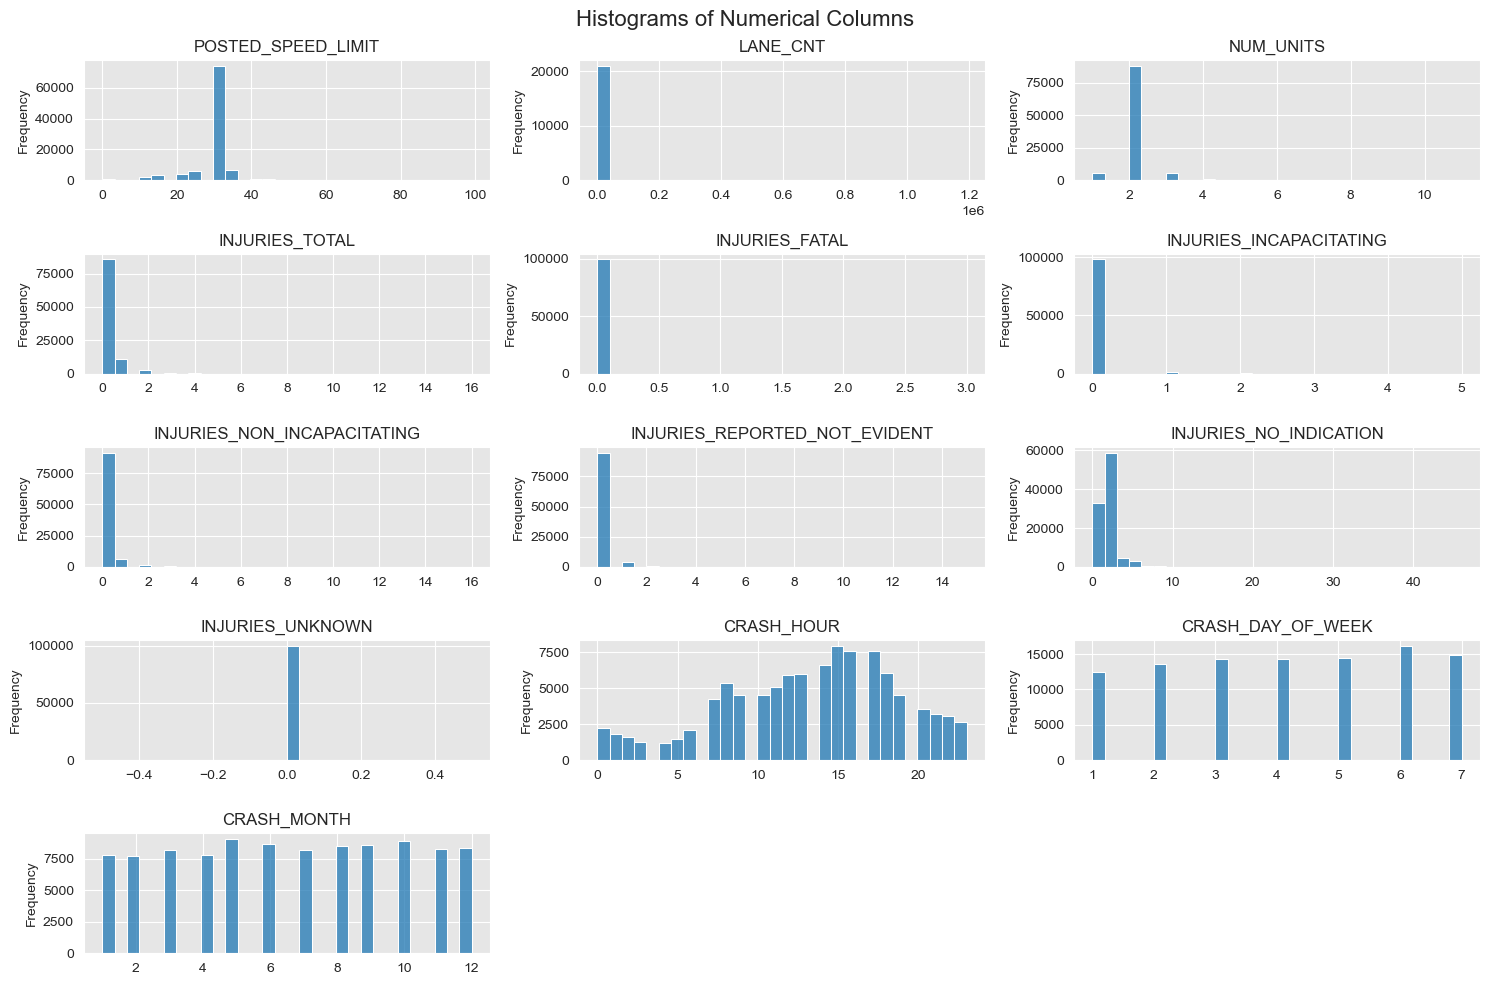

In [31]:
# Then we visualise these numerical columns in the data using histograms.

plt.figure(figsize=(15, 10))
plot_idx = 1
# Sampling the data for faster plotting and limit bins for speed(since the dataset is too large)
sampled_data = meaningful_numerical.sample(n=100000, random_state=42) if len(meaningful_numerical) > 10000 else meaningful_numerical

for col in sampled_data.columns:
    plt.subplot(5, 3, plot_idx)
    sns.histplot(sampled_data[col].dropna(), kde=False, bins=30)
    plt.title(col)
    plt.xlabel('')
    plt.ylabel('Frequency')
    plot_idx += 1
plt.suptitle('Histograms of Numerical Columns', fontsize=16)
plt.tight_layout()
plt.show()
plt.savefig('images/numerical_columns_histograms.png', dpi=300, bbox_inches='tight')

* We can also visualise the categorical columns to understand the better.

<Figure size 640x480 with 0 Axes>

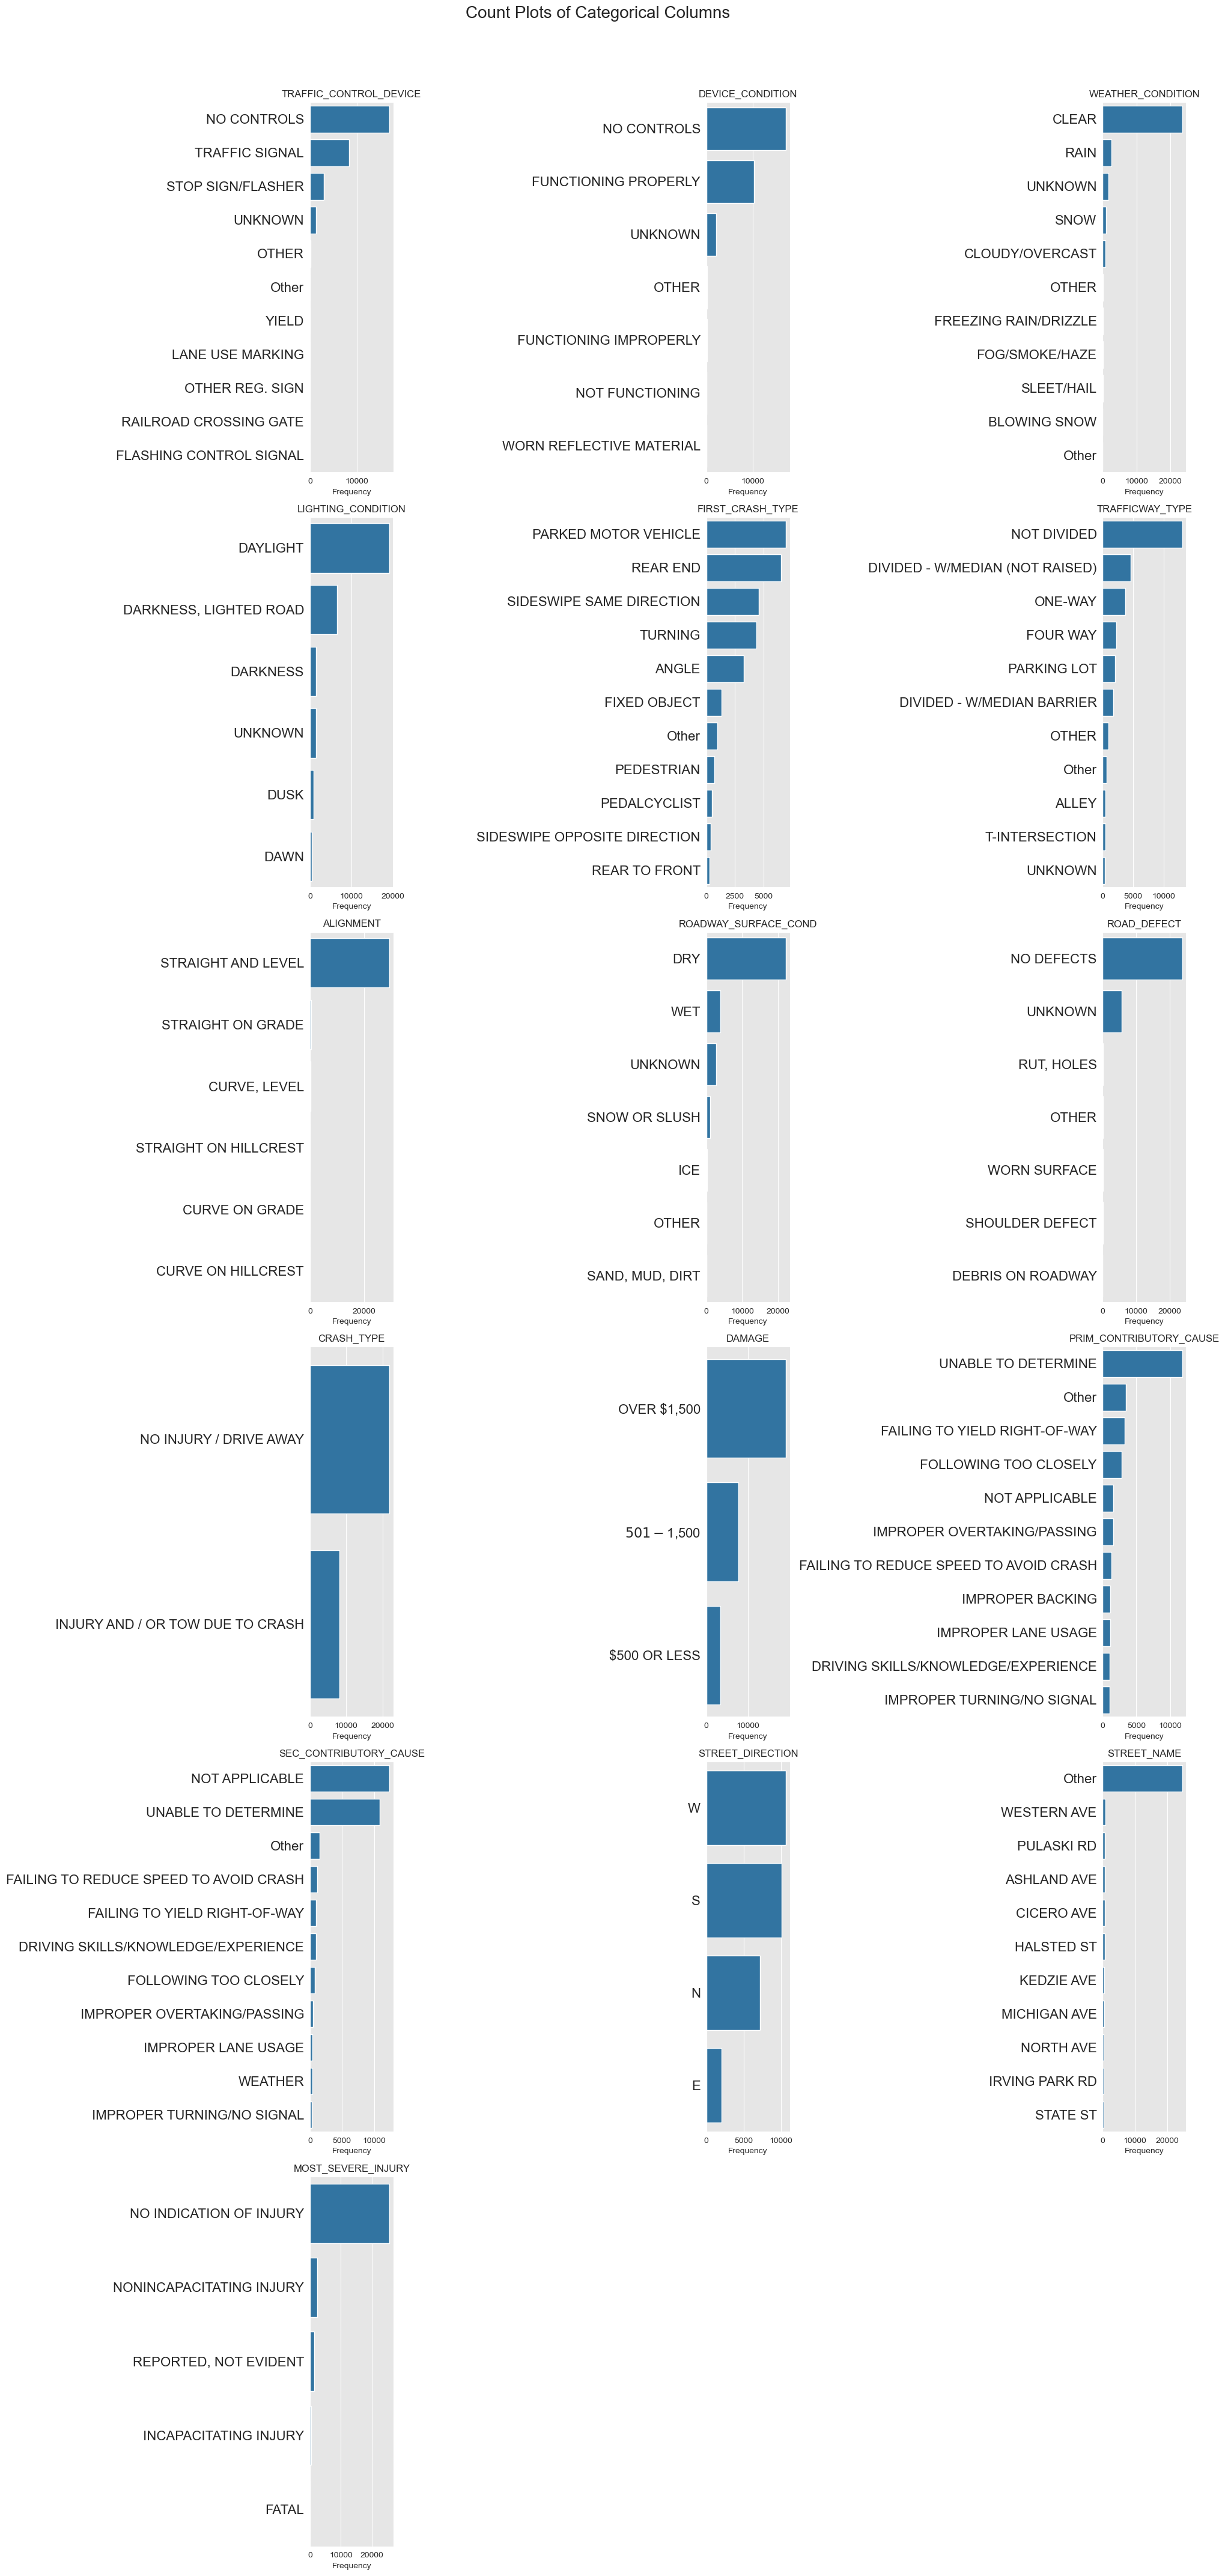

In [30]:
# Dropping columns like index and date columns that are not useful for analysis.
meaningful_categorical = raw_data[categorical].drop(columns=['CRASH_DATE', 'CRASH_RECORD_ID','CRASH_DATE_EST_I', 'DATE_POLICE_NOTIFIED','LOCATION'])

# Then we visualise these categorical columns in the data using count plots.
categorical_sampled_data = meaningful_categorical.sample(n=30000, random_state=42) if len(meaningful_categorical) > 0 else meaningful_categorical

# Remove columns with more than 1000 missing values before plotting
cols_to_skip = [col for col in categorical_sampled_data.columns if categorical_sampled_data[col].isnull().sum() > 1000]

# Limit the number of unique values to plot for each column to speed up plotting
max_categories = 10

n_cols = 3
cols_to_plot = [col for col in categorical_sampled_data.columns if col not in cols_to_skip]
n_rows = int(np.ceil(len(cols_to_plot) / n_cols))

# Create subplots for each categorical column
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 7 * n_rows), squeeze=False)
axes = axes.flatten()
for idx, col in enumerate(cols_to_plot):
    unique_vals = categorical_sampled_data[col].nunique(dropna=False)
    plot_data = categorical_sampled_data[col]
    if unique_vals > max_categories:
        top_cats = plot_data.value_counts().nlargest(max_categories).index
        plot_data = plot_data.where(plot_data.isin(top_cats), other='Other')
    sns.countplot(y=plot_data, order=plot_data.value_counts().index, ax=axes[idx])
    axes[idx].set_title(col)
    axes[idx].set_xlabel('Frequency')
    axes[idx].set_ylabel('')
    axes[idx].tick_params(axis='y', labelrotation=0, labelsize=16)
for j in range(len(cols_to_plot), len(axes)):
    fig.delaxes(axes[j])
plt.suptitle('Count Plots of Categorical Columns', fontsize=20, y=1.02)
plt.subplots_adjust(top=0.9, hspace=0.4)
plt.tight_layout()
plt.show()
plt.savefig('images/categorical_columns_countplots.png', dpi=300, bbox_inches='tight')


**Understanding and describing the data.**

## DATA PREPARATION

### Data Cleaning and Feature Engineering.

## DATA MODELLING

## EVALUATION

## CONCLUSIONS

**General Recommendations**

**Best Model**

**Nest Steps**